<center><h1>Classificação multiclasse de imagens satelitais<h1></center>

<p><strong>PAVIC-Lab</strong></p>
<p><strong>Módulo III - Aprendizado de Máquina</strong></p>
<p><strong>Professor: </strong>Salomão Mafalda</p>
<p><strong>Autor: </strong>Wallison Ferreira</p>

[Link para o trabalho relacionado](https://www.kaggle.com/datasets/horton1314/ustssmoker/data)

## 0 Importar bibliotecas

In [ ]:
import torch
from torch import nn


import warnings
warnings.filterwarnings('ignore')

torch.__version__

'2.1.2+cu121'

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
from torchinfo import summary
from pavic_treinamento_ml.going_modular.going_modular import data_setup, engine

/home/wallison/Downloads/relatorio_final_pavic/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1 Aquisição de dados

### Varredura do dataset

In [4]:
import os

def walk_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"{len(dirnames)} pastas e {len(filenames)} imagens em [{dirpath}].")

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("dataset/dataset_splitted_smokers_min")
image_path = data_path

In [6]:
walk_dir(image_path)

3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/train].
0 pastas e 807 imagens em [dataset/dataset_splitted_smokers_min/train/Dust].
0 pastas e 812 imagens em [dataset/dataset_splitted_smokers_min/train/Smoke].
0 pastas e 931 imagens em [dataset/dataset_splitted_smokers_min/train/Cloud].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/test].
0 pastas e 102 imagens em [dataset/dataset_splitted_smokers_min/test/Dust].
0 pastas e 103 imagens em [dataset/dataset_splitted_smokers_min/test/Smoke].
0 pastas e 117 imagens em [dataset/dataset_splitted_smokers_min/test/Cloud].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/val].
0 pastas e 100 imagens em [dataset/dataset_splitted_smokers_min/val/Dust].
0 pastas e 101 imagens em [dataset/dataset_splitted_smokers_min/val/Smoke].
0 pastas e 116 imagens em [dataset/dataset_splitted_smokers_min/val/Cloud].


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('dataset/dataset_splitted_smokers_min/train'),
 PosixPath('dataset/dataset_splitted_smokers_min/test'))

Path:  dataset/dataset_splitted_smokers_min/train/Smoke/smoke_955.tif
Class:  Smoke
Height:  256
Width:  256


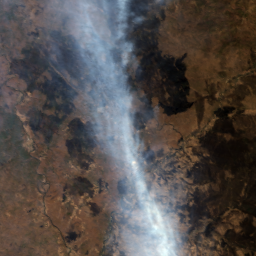

In [8]:
# Visualizar uma imagem

import random
from PIL import Image

#1 ler todos 'caminhos' das imagens
image_path_list = list(image_path.glob("*/*/*.tif"))

#2 selecionar imagem random
random_image_path = random.choice(image_path_list)

#3 selecionar classe
image_class = random_image_path.parent.stem

#4 ler img
img = Image.open(random_image_path)

print("Path: ", random_image_path)
print("Class: ", image_class)
print("Height: ", img.height)
print("Width: ", img.width)
img

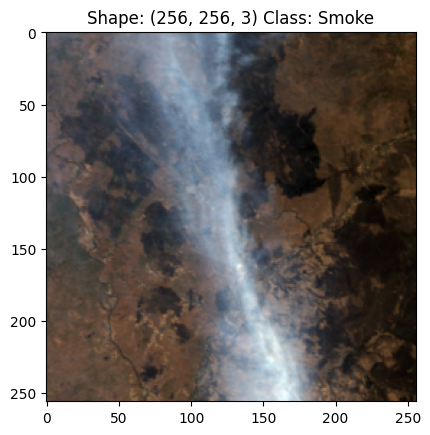

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.imshow(img_array);
plt.title(f"Shape: {img_array.shape} Class: {image_class}");

## 2 Load to Tensors

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3):

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size:{f.size}")
      ax[0].axis("off")
      #[C, H, W]-[3, 64, 64]-[0, 1, 2]-[64, 64, 3]-[H, W , C]
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



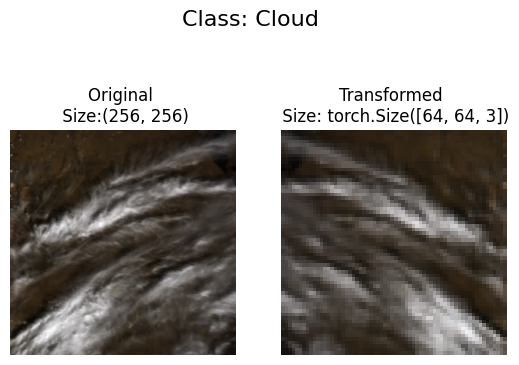

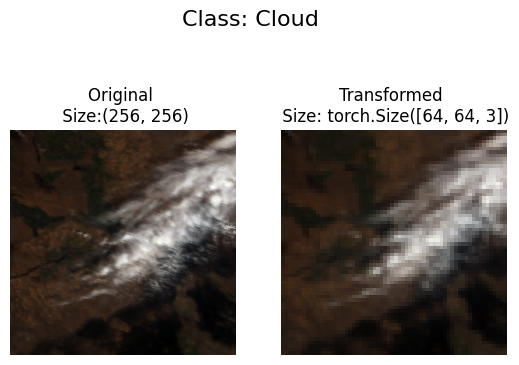

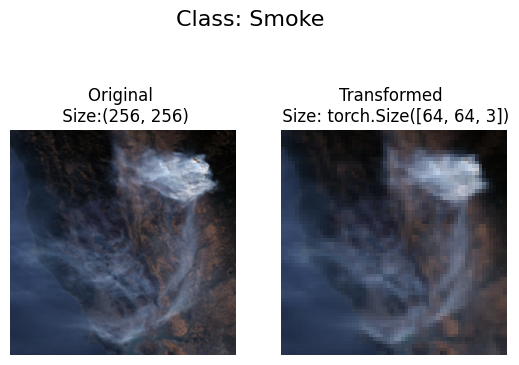

In [13]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Opção 1: Carregar os dados com Image Folder

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 2550
    Root location: dataset/dataset_splitted_smokers_min/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
#get class
class_names = train_data.classes
class_names

['Cloud', 'Dust', 'Smoke']

## 3 Carregar para o Dataloader

## Opção 2: Carregar os dados com Custom Dataset

In [15]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [17]:
#função para retornar lista de classes e dicionario de classes
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Classes nao encontradas na pasta {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [18]:
find_classes(train_dir)

(['Cloud', 'Dust', 'Smoke'], {'Cloud': 0, 'Dust': 1, 'Smoke': 2})

## 3 Preparando a Rede Neural Efficient Net

In [16]:
import torchvision

from torch import nn
from torchvision import transforms

In [17]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

Define transformers manuais

In [18]:
manual_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Define transformers automático

In [19]:
#carregamento automatico do transform
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
#criar o dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=16
)

Summary

In [21]:
summary(model=model,
        input_size=(16, 3, 256, 256),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 256, 256]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 256, 256]    [16, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 256, 256]    [16, 32, 128, 128]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 256, 256]    [16, 32, 128, 128]   864                  True
│    │    └─BatchNorm2d (1)                                  [16, 32, 128, 128]   [16, 32, 128, 128]   64                   True
│    │    └─SiLU (2)                                         [16, 32, 128, 128]   [16, 32, 128, 128]   --                   --
│    └─Sequential (1)                                        [16, 32, 128, 128]   [16, 16, 128

### Congelar camadas

In [22]:
for param in model.features.parameters():
  param.requires_grad = False

In [23]:
output_shape = len(class_names)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=output_shape,
                    out_features=output_shape,
                    bias=True)).to(device)

In [24]:
summary(model=model,
        input_size=(1, 3, 16, 16),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 16, 16]       [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 16, 16]       [1, 1280, 1, 1]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 16, 16]       [1, 32, 8, 8]        --                   False
│    │    └─Conv2d (0)                                       [1, 3, 16, 16]       [1, 32, 8, 8]        (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 8, 8]        [1, 32, 8, 8]        (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 8, 8]        [1, 32, 8, 8]        --                   --
│    └─Sequential (1)                                        [1, 32, 8, 8]        [1, 1

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [26]:
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)
end_time = timer()

print(f"Tempo de treinamento: {end_time-start_time:.3f} segundos")

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [04:54<4:00:27, 294.44s/it]

Epoch: 1 | train_loss: 0.8359 | train_acc: 0.6785 | test_loss: 0.6429 | test_acc: 0.8304


  4%|▍         | 2/50 [08:58<3:31:49, 264.79s/it]

Epoch: 2 | train_loss: 0.5980 | train_acc: 0.8193 | test_loss: 0.4696 | test_acc: 0.8869


  6%|▌         | 3/50 [13:30<3:30:01, 268.11s/it]

Epoch: 3 | train_loss: 0.4833 | train_acc: 0.8535 | test_loss: 0.3840 | test_acc: 0.8869


  8%|▊         | 4/50 [18:00<3:26:06, 268.83s/it]

Epoch: 4 | train_loss: 0.4203 | train_acc: 0.8590 | test_loss: 0.3162 | test_acc: 0.9137


 10%|█         | 5/50 [22:33<3:22:50, 270.46s/it]

Epoch: 5 | train_loss: 0.3652 | train_acc: 0.8762 | test_loss: 0.2915 | test_acc: 0.9107


 12%|█▏        | 6/50 [26:29<3:09:36, 258.56s/it]

Epoch: 6 | train_loss: 0.3400 | train_acc: 0.8820 | test_loss: 0.2648 | test_acc: 0.9226


 14%|█▍        | 7/50 [30:40<3:03:28, 256.02s/it]

Epoch: 7 | train_loss: 0.3090 | train_acc: 0.8938 | test_loss: 0.2397 | test_acc: 0.9256


 16%|█▌        | 8/50 [35:12<3:02:51, 261.23s/it]

Epoch: 8 | train_loss: 0.3050 | train_acc: 0.8892 | test_loss: 0.2190 | test_acc: 0.9226


 18%|█▊        | 9/50 [39:46<3:01:19, 265.35s/it]

Epoch: 9 | train_loss: 0.2967 | train_acc: 0.8921 | test_loss: 0.2224 | test_acc: 0.9226


 20%|██        | 10/50 [44:02<2:54:56, 262.40s/it]

Epoch: 10 | train_loss: 0.2879 | train_acc: 0.8973 | test_loss: 0.2150 | test_acc: 0.9256


 22%|██▏       | 11/50 [47:45<2:42:39, 250.23s/it]

Epoch: 11 | train_loss: 0.2976 | train_acc: 0.8999 | test_loss: 0.2133 | test_acc: 0.9256


 24%|██▍       | 12/50 [52:18<2:42:52, 257.18s/it]

Epoch: 12 | train_loss: 0.2687 | train_acc: 0.9061 | test_loss: 0.2293 | test_acc: 0.9167


 26%|██▌       | 13/50 [56:51<2:41:36, 262.08s/it]

Epoch: 13 | train_loss: 0.2919 | train_acc: 0.8887 | test_loss: 0.2166 | test_acc: 0.9286


 28%|██▊       | 14/50 [1:01:03<2:35:25, 259.05s/it]

Epoch: 14 | train_loss: 0.2892 | train_acc: 0.8930 | test_loss: 0.2156 | test_acc: 0.9256


 30%|███       | 15/50 [1:04:46<2:24:46, 248.17s/it]

Epoch: 15 | train_loss: 0.2647 | train_acc: 0.9036 | test_loss: 0.2110 | test_acc: 0.9137


 32%|███▏      | 16/50 [1:08:26<2:15:43, 239.50s/it]

Epoch: 16 | train_loss: 0.2475 | train_acc: 0.9055 | test_loss: 0.2027 | test_acc: 0.9256


 34%|███▍      | 17/50 [1:12:05<2:08:19, 233.33s/it]

Epoch: 17 | train_loss: 0.2701 | train_acc: 0.9009 | test_loss: 0.2016 | test_acc: 0.9286


 36%|███▌      | 18/50 [1:16:13<2:06:55, 238.00s/it]

Epoch: 18 | train_loss: 0.2675 | train_acc: 0.8986 | test_loss: 0.1943 | test_acc: 0.9256


 38%|███▊      | 19/50 [1:20:22<2:04:33, 241.09s/it]

Epoch: 19 | train_loss: 0.2384 | train_acc: 0.9091 | test_loss: 0.2077 | test_acc: 0.9315


 40%|████      | 20/50 [1:24:01<1:57:20, 234.68s/it]

Epoch: 20 | train_loss: 0.2737 | train_acc: 0.8954 | test_loss: 0.2062 | test_acc: 0.9315


 42%|████▏     | 21/50 [1:27:41<1:51:12, 230.09s/it]

Epoch: 21 | train_loss: 0.2555 | train_acc: 0.9076 | test_loss: 0.2040 | test_acc: 0.9405


 44%|████▍     | 22/50 [1:31:45<1:49:19, 234.27s/it]

Epoch: 22 | train_loss: 0.2474 | train_acc: 0.9130 | test_loss: 0.2090 | test_acc: 0.9375


 46%|████▌     | 23/50 [1:35:58<1:47:55, 239.83s/it]

Epoch: 23 | train_loss: 0.2469 | train_acc: 0.9189 | test_loss: 0.2207 | test_acc: 0.9226


 48%|████▊     | 24/50 [1:39:39<1:41:33, 234.35s/it]

Epoch: 24 | train_loss: 0.2399 | train_acc: 0.9109 | test_loss: 0.1884 | test_acc: 0.9315


 50%|█████     | 25/50 [1:43:20<1:35:54, 230.20s/it]

Epoch: 25 | train_loss: 0.2419 | train_acc: 0.9098 | test_loss: 0.1999 | test_acc: 0.9315


 52%|█████▏    | 26/50 [1:47:00<1:30:55, 227.32s/it]

Epoch: 26 | train_loss: 0.2322 | train_acc: 0.9145 | test_loss: 0.1822 | test_acc: 0.9345


 54%|█████▍    | 27/50 [1:50:40<1:26:17, 225.11s/it]

Epoch: 27 | train_loss: 0.2598 | train_acc: 0.9090 | test_loss: 0.2053 | test_acc: 0.9286


 56%|█████▌    | 28/50 [1:54:21<1:22:00, 223.64s/it]

Epoch: 28 | train_loss: 0.2337 | train_acc: 0.9158 | test_loss: 0.1984 | test_acc: 0.9345


 58%|█████▊    | 29/50 [1:58:24<1:20:19, 229.48s/it]

Epoch: 29 | train_loss: 0.2483 | train_acc: 0.9160 | test_loss: 0.2058 | test_acc: 0.9345


 60%|██████    | 30/50 [2:02:54<1:20:35, 241.79s/it]

Epoch: 30 | train_loss: 0.2142 | train_acc: 0.9207 | test_loss: 0.2014 | test_acc: 0.9286


 62%|██████▏   | 31/50 [2:07:19<1:18:46, 248.78s/it]

Epoch: 31 | train_loss: 0.2474 | train_acc: 0.9066 | test_loss: 0.1893 | test_acc: 0.9315


 64%|██████▍   | 32/50 [2:11:33<1:15:04, 250.26s/it]

Epoch: 32 | train_loss: 0.2396 | train_acc: 0.9099 | test_loss: 0.1899 | test_acc: 0.9315


 66%|██████▌   | 33/50 [2:15:12<1:08:17, 241.03s/it]

Epoch: 33 | train_loss: 0.2524 | train_acc: 0.9056 | test_loss: 0.2049 | test_acc: 0.9315


 68%|██████▊   | 34/50 [2:19:29<1:05:28, 245.55s/it]

Epoch: 34 | train_loss: 0.2440 | train_acc: 0.9134 | test_loss: 0.2081 | test_acc: 0.9286


 70%|███████   | 35/50 [2:23:51<1:02:40, 250.71s/it]

Epoch: 35 | train_loss: 0.2231 | train_acc: 0.9187 | test_loss: 0.2022 | test_acc: 0.9286


 72%|███████▏  | 36/50 [2:27:54<57:57, 248.38s/it]  

Epoch: 36 | train_loss: 0.2090 | train_acc: 0.9195 | test_loss: 0.1919 | test_acc: 0.9345


 74%|███████▍  | 37/50 [2:31:35<52:00, 240.04s/it]

Epoch: 37 | train_loss: 0.2382 | train_acc: 0.9168 | test_loss: 0.2048 | test_acc: 0.9345


 76%|███████▌  | 38/50 [2:35:29<47:40, 238.40s/it]

Epoch: 38 | train_loss: 0.2289 | train_acc: 0.9145 | test_loss: 0.1824 | test_acc: 0.9435


 78%|███████▊  | 39/50 [2:39:38<44:15, 241.38s/it]

Epoch: 39 | train_loss: 0.2445 | train_acc: 0.9086 | test_loss: 0.2203 | test_acc: 0.9256


 80%|████████  | 40/50 [2:43:41<40:18, 241.81s/it]

Epoch: 40 | train_loss: 0.2306 | train_acc: 0.9115 | test_loss: 0.1965 | test_acc: 0.9286


 82%|████████▏ | 41/50 [2:48:02<37:10, 247.81s/it]

Epoch: 41 | train_loss: 0.2328 | train_acc: 0.9189 | test_loss: 0.2198 | test_acc: 0.9315


 84%|████████▍ | 42/50 [2:52:33<33:57, 254.72s/it]

Epoch: 42 | train_loss: 0.2608 | train_acc: 0.9025 | test_loss: 0.2167 | test_acc: 0.9315


 86%|████████▌ | 43/50 [2:57:26<31:03, 266.25s/it]

Epoch: 43 | train_loss: 0.2261 | train_acc: 0.9165 | test_loss: 0.2198 | test_acc: 0.8988


 88%|████████▊ | 44/50 [3:02:09<27:07, 271.30s/it]

Epoch: 44 | train_loss: 0.2516 | train_acc: 0.9107 | test_loss: 0.1858 | test_acc: 0.9286


 90%|█████████ | 45/50 [3:06:09<21:48, 261.72s/it]

Epoch: 45 | train_loss: 0.2258 | train_acc: 0.9195 | test_loss: 0.2049 | test_acc: 0.9345


 92%|█████████▏| 46/50 [3:09:57<16:46, 251.68s/it]

Epoch: 46 | train_loss: 0.2311 | train_acc: 0.9120 | test_loss: 0.2037 | test_acc: 0.9107


 94%|█████████▍| 47/50 [3:13:55<12:22, 247.64s/it]

Epoch: 47 | train_loss: 0.2264 | train_acc: 0.9141 | test_loss: 0.2003 | test_acc: 0.9286


 96%|█████████▌| 48/50 [3:18:05<08:16, 248.17s/it]

Epoch: 48 | train_loss: 0.2333 | train_acc: 0.9187 | test_loss: 0.1903 | test_acc: 0.9345


 98%|█████████▊| 49/50 [3:22:26<04:12, 252.19s/it]

Epoch: 49 | train_loss: 0.2337 | train_acc: 0.9121 | test_loss: 0.2147 | test_acc: 0.9315


100%|██████████| 50/50 [3:26:47<00:00, 248.16s/it]

Epoch: 50 | train_loss: 0.2365 | train_acc: 0.9121 | test_loss: 0.1957 | test_acc: 0.9375


Tempo de treinamento: 12408.576 segundos


In [27]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 5.1 Plot train info

In [28]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))
  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

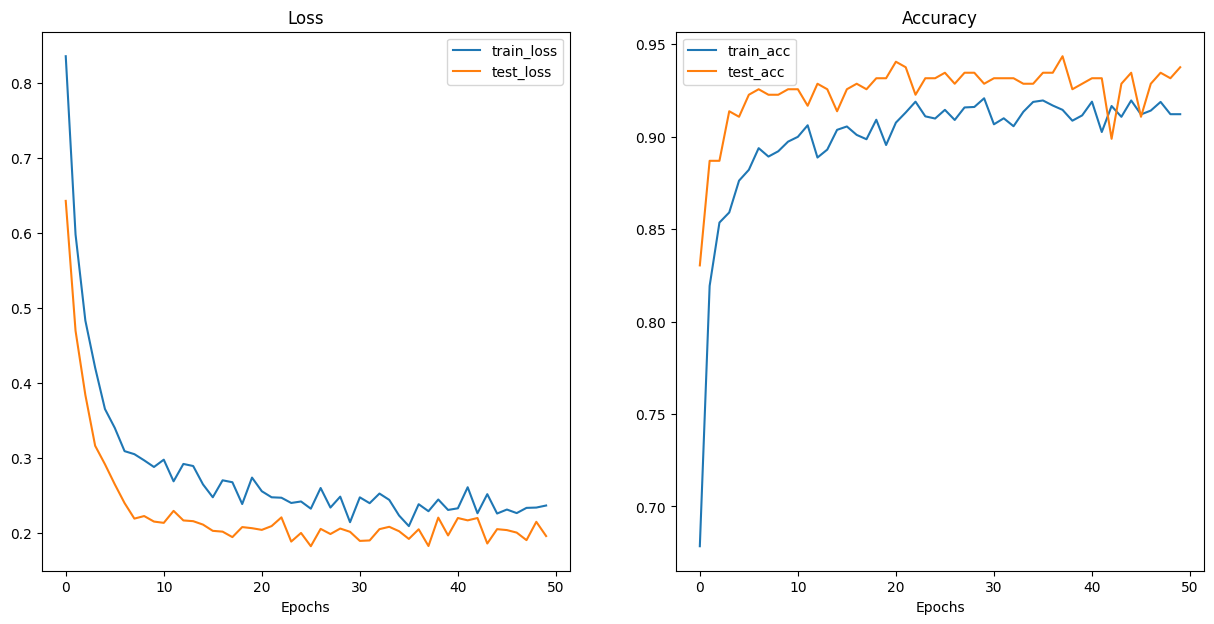

In [29]:
plot_loss_curves(results)